In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.express as px
import plotly.figure_factory as ff
from pandas_datareader import data as wb
import sklearn as sk
import statistics as stat
import seaborn as sns

In [3]:
tickers = ["AAL","DIS","PEP","^GSPC"]

In [100]:
import yfinance as yf

data = {}

for ticker in tickers:
    data[ticker] = yf.Ticker(ticker).history(period = "1d", start = "2009-01-01", end = "2021-07-12")

In [101]:
market = data["^GSPC"]
market["daily_returns"] = ((data["^GSPC"].Close - data["^GSPC"].Close.shift(1))/data["^GSPC"].Close.shift(1))*100
market["std_252"] = (market["daily_returns"].rolling(252).std())**2
market["var_252"] = market["std_252"] ** 2

In [102]:
# basic indicators
market_var = data["^GSPC"].Close.rolling(252).std()
for ticker in tickers[:-1]:
    x = data[ticker]
    x["daily_returns"] = ((x.Close - x.Close.shift(1))/x.Close.shift(1))*100
    x["std_10"] = x.daily_returns.rolling(10).std()
    x["std_45"] = x.daily_returns.rolling(45).std()
    x["std_252"] = x.daily_returns.rolling(252).std()
    x["market_daily_returns"] = market["daily_returns"]
    x["beta"] = x["daily_returns"].rolling(252).cov(x["market_daily_returns"].rolling(252))/market["var_252"]
    x["residual_volatility"] = (x.std_252 ** 2 - x.beta * market.var_252) ** 0.5
    
# price transform/ cycle indicators
for ticker in tickers[:-1]:
    x = data[ticker]
    x["Typical Price"] = (x.High.shift(1) + x.Low.shift(1) + x.Close.shift(1))/3
    
# Overlap Indicators
for ticker in tickers[:-1]:
    x = data[ticker]
    for i in [10, 45, 252]:
        x["BBAND_" + str(i)] = x.Close.rolling(i).mean()
        x["BBAND_UP_" + str(i)] = x["BBAND_" + str(i)] + 2 * x.Close.rolling(i).std()
        x["BBAND_DOWN_" + str(i)] = x["BBAND_" + str(i)] - 2 * x.Close.rolling(i).std()
        x["SMA_" + str(i)] = x.Close.rolling(i).mean()
        x["EMA_" + str(i)] = x.Close.shift(1).ewm(span = i, adjust = False).mean()
        x["ER_"+str(i)] = (x.Close.shift(1) - x.Close.shift(i+1))/(x.High - x.Low).shift(1).rolling(i).sum()

        
def rsi(df, periods):
    prev_day_daily_returns = df.daily_returns.shift(1)
    #df["prev_day_close"] = df.Close.shift(1)
    rsi = [None for i in range(periods+1)]
    for i in range(periods+1,len(df)):
        gain = 0
        loss = 0
        for j in range(i, i - periods - 1, -1):
            retrn = prev_day_daily_returns[j]
            if retrn > 0:
                gain += retrn
            else:
                loss += retrn
        rsi.append(100 - (100/(1 + gain/(-loss))))
    return rsi

def stoch_k(df, periods):
    prev_day_close = df.Close.shift(1)
    prev_day_high = df.High.shift(1)
    prev_day_low = df.Low.shift(1)
    stochf_k = [None for i in range(periods+1)]
    stoch_k = [None for i in range(max(15,periods+1))]
    for i in range(periods+1, len(df)):
        max_high = max(prev_day_high[i-periods:i])
        min_low = min(prev_day_low[i-periods:i])
        stochf_k.append((prev_day_close[i]-min_low) * 100/(max_high-min_low))
        if i>=15:
            max_14high = max(prev_day_high[i-14:i])
            min_14low = min(prev_day_low[i-14:i])
            num_sum = 0
            denom_sum = 0
            for j in range(i-periods-1, i-1):
                num_sum += (prev_day_close[j] - min_14low)
                denom_sum += (max_14high - min_14low)
            stoch_k.append(num_sum * 100 / denom_sum)
    return stochf_k, stoch_k

def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

        

# momentum indicators
for ticker in tickers:
    x = data[ticker]
    for i in [10, 45, 252]:
        x["ROC_"+str(i)] = (x.Close.shift(1)/x.Close.shift(i+1)) - 1
        x["RSI_"+str(i)] = rsi(x, i)
        x["STOCHF_K_"+str(i)], x["STOCH_K_"+str(i)] = stoch_k(x, i)
        x["STOCHF_D_"+str(i)] = x["STOCHF_K_"+str(i)].rolling(i).mean()
        x["STOCH_D_"+str(i)] = x["STOCH_K_"+str(i)].rolling(i).mean()
        x["PLUS_DI_"+str(i)], x["MINUS_DI_"+str(i)], x["ADX_"+str(i)] = get_adx(x['High'], x['Low'], x['Close'], i)
        

<ipython-input-102-51a554129f80>:43: RuntimeWarning: divide by zero encountered in double_scalars
  rsi.append(100 - (100/(1 + gain/(-loss))))
<ipython-input-102-51a554129f80>:43: RuntimeWarning: divide by zero encountered in double_scalars
  rsi.append(100 - (100/(1 + gain/(-loss))))


In [107]:
def get_cmo(close, prev_close, lookback):
    cmo = [None for i in range(lookback+1)]
    for i in range(lookback+1, len(close)):
        pos_sum = 0
        neg_sum = 0
        for j in range(i-lookback,i):
            if close[j] - prev_close[j] > 0:
                pos_sum += close[j] - prev_close[j]
            else:
                neg_sum += abs(close[j] - prev_close[j])
        cmo.append((pos_sum - neg_sum) * 100/(pos_sum + neg_sum))
    return cmo

# momentum indicators - chande momentum oscillator
for ticker in tickers:
    x = data[ticker]
    for i in [10, 45, 252]:
        x["CMO_"+str(i)] = get_cmo(x.Close, x.Close.shift(1), i)

In [110]:
def get_range(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    natr = [atr[i] * 100/close[i] for i in range(len(close))]
    
    return tr, atr, natr

# volume and volatility indicators - true range, average true range, normalized average true range
for ticker in tickers:
    x = data[ticker]
    for i in [10, 45, 252]:
        x["TR_"+str(i)], x["ATR_"+str(i)], x["NATR_"+str(i)] = get_range(x.High, x.Low, x.Close, i)

In [111]:
data["AAL"]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,std_10,std_45,...,CMO_252,TR_10,ATR_10,NATR_10,TR_45,ATR_45,NATR_45,TR_252,ATR_252,NATR_252
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,7.287393,7.994449,7.230828,7.909603,5167000,0.0,0,NaN,NaN,NaN,...,NaN,0.763620,NaN,NaN,0.763620,NaN,NaN,0.763620,NaN,NaN
2009-01-05,7.900174,7.909602,7.504223,7.853037,3457100,0.0,0,-0.715153,NaN,NaN,...,NaN,0.405380,NaN,NaN,0.405380,NaN,NaN,0.405380,NaN,NaN
2009-01-06,7.683342,8.682649,7.664488,8.541238,5731000,0.0,0,8.763501,NaN,NaN,...,NaN,1.018161,NaN,NaN,1.018161,NaN,NaN,1.018161,NaN,NaN
2009-01-07,8.164141,8.927761,8.164141,8.560092,5468900,0.0,0,0.220742,NaN,NaN,...,NaN,0.763621,NaN,NaN,0.763621,NaN,NaN,0.763621,NaN,NaN
2009-01-08,8.437539,9.116313,8.126434,9.022038,5196400,0.0,0,5.396513,NaN,NaN,...,NaN,0.989879,NaN,NaN,0.989879,NaN,NaN,0.989879,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,21.620001,21.650000,21.110001,21.480000,20814100,0.0,0,-0.139473,1.525176,2.137848,...,7.996323,0.539999,0.558,2.597764,0.539999,0.768889,3.579557,0.539999,0.873810,4.068015
2021-07-06,21.500000,21.790001,20.860001,21.010000,24176500,0.0,0,-2.188079,1.573314,2.142391,...,8.274971,0.930000,0.587,2.793907,0.930000,0.771778,3.673383,0.930000,0.874683,4.163172
2021-07-07,20.790001,21.049999,20.170000,20.309999,30857000,0.0,0,-3.331750,1.776203,2.190119,...,7.553592,0.879999,0.615,3.028064,0.879999,0.777778,3.829531,0.879999,0.874643,4.306464


In [114]:
data["AAL"].corr().tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,daily_returns,std_10,std_45,...,CMO_252,TR_10,ATR_10,NATR_10,TR_45,ATR_45,NATR_45,TR_252,ATR_252,NATR_252
CMO_252,0.120937,0.119216,0.122963,0.121828,-0.294624,-0.018439,NaN,0.001139,-0.297202,-0.357524,...,1.000000,-0.044960,-0.073443,-0.313639,-0.044960,-0.118888,-0.384085,-0.044960,-0.344994,-0.626465
TR_10,0.548915,0.559435,0.534597,0.546336,0.323801,0.034806,NaN,0.010873,-0.014950,-0.188377,...,-0.044960,1.000000,0.719558,-0.055810,1.000000,0.637382,-0.182996,1.000000,0.534432,-0.192185
ATR_10,0.734945,0.739826,0.728152,0.733666,0.193565,0.081429,NaN,-0.032164,-0.004658,-0.230312,...,-0.073443,0.719558,1.000000,-0.026981,0.719558,0.882511,-0.206675,0.719558,0.748595,-0.236738
NATR_10,-0.552209,-0.549259,-0.558253,-0.554931,0.329565,-0.032709,NaN,-0.091652,0.896371,0.827483,...,-0.313639,-0.055810,-0.026981,1.000000,-0.055810,-0.169197,0.837877,-0.055810,-0.220942,0.655459
TR_45,0.548915,0.559435,0.534597,0.546336,0.323801,0.034806,NaN,0.010873,-0.014950,-0.188377,...,-0.044960,1.000000,0.719558,-0.055810,1.000000,0.637382,-0.182996,1.000000,0.534432,-0.192185
ATR_45,0.811457,0.814299,0.807254,0.810424,0.165241,0.072871,NaN,-0.038315,-0.167399,-0.210919,...,-0.118888,0.637382,0.882511,-0.169197,0.637382,1.000000,-0.148353,0.637382,0.869970,-0.191747
NATR_45,-0.553643,-0.552445,-0.556800,-0.555460,0.314182,-0.038973,NaN,-0.026261,0.722553,0.889083,...,-0.384085,-0.182996,-0.206675,0.837877,-0.182996,-0.148353,1.000000,-0.182996,-0.190900,0.822443
TR_252,0.548915,0.559435,0.534597,0.546336,0.323801,0.034806,NaN,0.010873,-0.014950,-0.188377,...,-0.044960,1.000000,0.719558,-0.055810,1.000000,0.637382,-0.182996,1.000000,0.534432,-0.192185
ATR_252,0.802554,0.804420,0.799689,0.801551,0.141496,0.072539,NaN,-0.031230,-0.196688,-0.232384,...,-0.344994,0.534432,0.748595,-0.220942,0.534432,0.869970,-0.190900,0.534432,1.000000,-0.141169
NATR_252,-0.621835,-0.620723,-0.625241,-0.624253,0.555800,-0.042463,NaN,-0.043708,0.577378,0.778510,...,-0.626465,-0.192185,-0.236738,0.655459,-0.192185,-0.191747,0.822443,-0.192185,-0.141169,1.000000


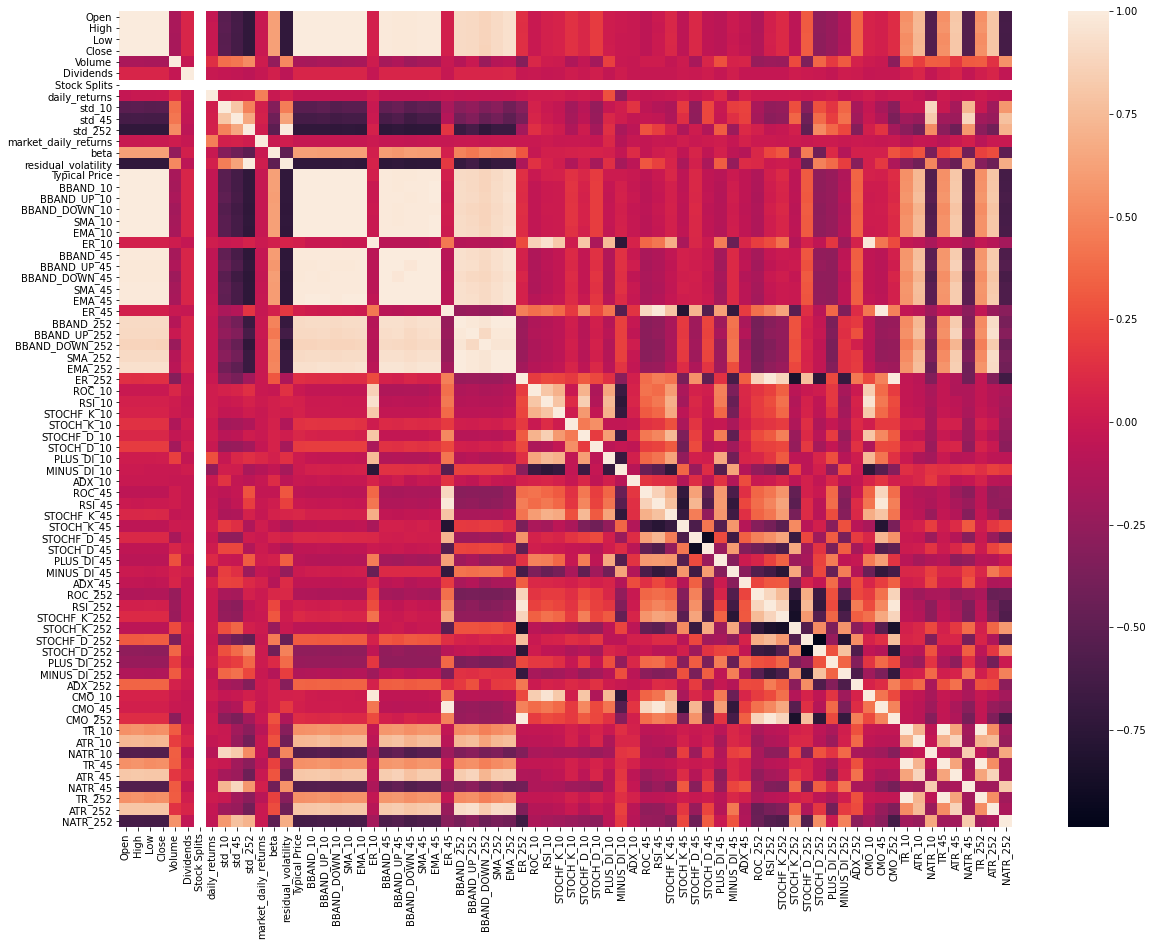

In [119]:
plt.figure(figsize = (20,15))
sns.heatmap(data["AAL"].corr())

In [122]:
for ticker in tickers[:-1]:
    data[ticker].loc[data[ticker].index >= "2010-01-01"].to_csv(ticker+".csv")

In [ ]:
data["AAL"].loc[]